<a href="https://colab.research.google.com/github/dcnoye/misc/blob/master/jupyter_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from datetime import datetime as dt
import pandas_datareader.data as web

# plotly packages
from plotly.offline import plot
import plotly.express as px

api_key=""

In [3]:
class SelectMultipleInteract(widgets.HBox):

    def __init__(self):
        self.W1 = widgets.SelectMultiple(
            options=['FB', 'AMZN', 'AAPL','IBM','GOOGL','MSFT','NAV','O','QCOM','TSLA'],
            value=('FB','O'),
            description='symbol',
            rows=10,
            disabled=False
        )
        self.W2 = widgets.Select(
            options=['EWMA', 'SMA'],
            value='SMA',
            disabled=False
        )
        self.W3 = widgets.DatePicker(
            description='Pick a Start Date',
            value=dt.fromtimestamp(1347517370),
            disabled=False
        )
        self.W4 = widgets.DatePicker(
            description='Pick a End Date',
            value=dt.fromtimestamp(1447517370),
            disabled=False
        )
        self.W5 = widgets.IntSlider(
            value=14,
            min=10,
            max=20,
            step=1,
            description='Moving Window:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self.selectors = [self.W1, self.W2, self.W3, self.W4, self.W5]
        print(self.selectors)
        super().__init__(children=self.selectors)
        self._set_observes()

    def _set_observes(self):
        for widg in self.selectors:
            widg.observe(self._observed_function, names='value')

    def _observed_function(self, widg):
        for widg in self.selectors:
            print(widg.description)
            print(widg.get_interact_value())

In [9]:
%%capture hide
x = SelectMultipleInteract()

In [10]:
display(x)

SelectMultipleInteract(children=(SelectMultiple(description='symbol', index=(0, 7), options=('FB', 'AMZN', 'AA…

In [11]:
print("ticker symbols", x.W1.value)

print(x.W2.value)

print("Start Date", x.W3.value)

print("End Date", x.W4.value)

print("Moving Window", x.W5.value)

ticker symbols ('FB', 'O')
SMA
Start Date 2012-09-13 06:22:50
End Date 2015-11-14 16:09:30
Moving Window 14


In [12]:
dm1 =  pd.DataFrame()
tickers = list(x.W1.value)
start = x.W3.value
end = x.W4.value
i = 0
while (i < len(tickers)):
    df = web.DataReader(tickers[i], "av-daily", start=start, end=end,  api_key=api_key)
    df['symbol'] = tickers[i]
    if dm1.empty:
        dm1 = df
    else:
        dm1 = pd.concat([dm1, df])

    i+=1      

print(dm1)

              open   high    low   close    volume symbol
2012-09-13  20.955  21.48  20.61  20.713  65041600     FB
2012-09-14  21.130  22.08  20.90  22.000  72819800     FB
2012-09-17  22.670  22.75  21.50  21.520  50667600     FB
2012-09-18  21.600  21.98  21.37  21.870  36760500     FB
2012-09-19  21.990  23.37  21.77  23.290  78782800     FB
...            ...    ...    ...     ...       ...    ...
2015-11-09  47.410  47.41  45.98  46.390   2676922      O
2015-11-10  46.460  47.07  46.39  46.940   2323375      O
2015-11-11  47.030  47.70  46.81  47.440   1658757      O
2015-11-12  47.360  47.80  47.17  47.440   2010424      O
2015-11-13  47.500  47.85  47.02  47.440   2187922      O

[1596 rows x 6 columns]


In [13]:
def RSI(ohlc, period=14, method='SMA'):
    delta = ohlc["close"].diff()
    up, down = delta.copy(), delta.copy()
    up[up <0] = 0
    if method == "SMA":
        gain = up.rolling(period).mean()
        loss = down.abs().rolling(period).mean()
    else:
        gain = up.ewm(span=period).mean()
        loss = down.abs().ewm(span=period).mean()

    RS = gain / loss
    ohlc['RSI'] = pd.Series(100 - (100 / (1 + RS)), name="RSI")
    return ohlc

In [15]:
dm2 =  pd.DataFrame()
for symbol, df_symbol in dm1.groupby('symbol'):
    dx = RSI(df_symbol, int(x.W5.value),x.W2.value)
    if dm2.empty:
        dm2 = dx
    else:
        dm2 = pd.concat([dm2, dx])
dm2=dm2.reset_index()
print(dm2)

           index    open   high    low   close    volume symbol        RSI
0     2012-09-13  20.955  21.48  20.61  20.713  65041600     FB        NaN
1     2012-09-14  21.130  22.08  20.90  22.000  72819800     FB        NaN
2     2012-09-17  22.670  22.75  21.50  21.520  50667600     FB        NaN
3     2012-09-18  21.600  21.98  21.37  21.870  36760500     FB        NaN
4     2012-09-19  21.990  23.37  21.77  23.290  78782800     FB        NaN
...          ...     ...    ...    ...     ...       ...    ...        ...
1591  2015-11-09  47.410  47.41  45.98  46.390   2676922      O  27.052786
1592  2015-11-10  46.460  47.07  46.39  46.940   2323375      O  28.922237
1593  2015-11-11  47.030  47.70  46.81  47.440   1658757      O  26.303681
1594  2015-11-12  47.360  47.80  47.17  47.440   2010424      O  26.901961
1595  2015-11-13  47.500  47.85  47.02  47.440   2187922      O  25.560166

[1596 rows x 8 columns]


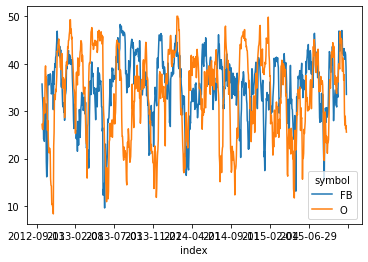

In [16]:
df = dm2.pivot(index='index', columns='symbol', values='RSI')
df.plot()

In [17]:
fig = px.line(dm2, x="index", y="RSI", color='symbol')
fig.show()